<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Fastai%20NLP%20course/6_Transfer_learning_computer_vision_and_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Review: computer vision transfer learning

[Video 9](https://youtu.be/5gCQvuznKn0?t=1596)

This is a subset of lesson 1 of https://course.fast.ai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64


What we are going to do is that we try to recognize the content of Oxford IIpet, 37 kind of pets

We are going to use the Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%.

In [0]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'
np.random.seed(2)
fnames = get_image_files(path_img)
fnames[0]

PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_169.jpg')

There are two things :

- annotations which is like whereabouts are the pets in it and then the images themselves
- image files

The first thing to do is to create a machine learning model of any kind what supervised model. Supervised model is the model that has label. In this case, the label is embedded in the file name so we need some way to label thse files based on finding everything before underscore digit and after forward clash in a file name 



```
/root/.fastai/data/oxford-iiit-pet/images/Birman_65.jpg'
```

What good way to do that --> regular expression


`pat = r'/([^/]+)_\d+.jpg$' `

- [^/] : capture everything that's not a slash
-  `+` : at least 1, try to find as many as it can
- _\d+ : capture followed by an underscore and followed by a digit one or more -> _65

p/s: /([^/]+) -> very common idiom which basically means find the first slash and then find lots of things that aren't slashes, or find a quote mark and then lots of things aren't quote marks . In case you are not familiar with regular expressions, you can seek `r'/([^/]+)_\d+.jpg$' ` 

We can excercise doing regular expressions here

In [0]:
fn = str(fnames[0]);fn

'/root/.fastai/data/oxford-iiit-pet/images/newfoundland_169.jpg'

In [0]:
re.findall(r'[0-9]',fn)

['1', '6', '9']

In [0]:
re.findall(r'/([^/])',fn)

['r', '.', 'd', 'o', 'i', 'n']

In [0]:
re.findall(r'/([^/]+)',fn)

['root',
 '.fastai',
 'data',
 'oxford-iiit-pet',
 'images',
 'newfoundland_169.jpg']

In [0]:
re.findall(r'/([^/]+)_',fn)

['newfoundland']

`\d+.jpg$` : why do we put these thing here . Because it's a good way to check things are formatted the way you thought they are , so it will give an error if it failed to find something , for example: the format is PNG, it would give an error that it doesn't match

I has a labelling thing which can find something from a name using regular expressions

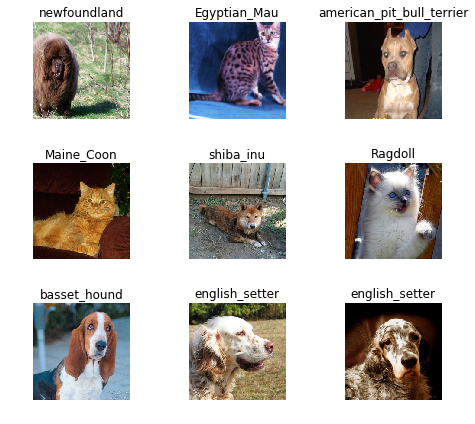

In [0]:
pat =r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img,fnames,pat,ds_tfms = get_transforms(),size=224,bs=bs).normalize(imagenet_stats)
data.show_batch(rows=3,figsize=(7,6))

## Training

We now create a model 

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22808827.87it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.400908,0.357389,0.107578,01:25
1,0.565695,0.257745,0.079838,01:26
2,0.347059,0.212592,0.069012,01:26
3,0.271098,0.202887,0.062923,01:26


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.216630,0.193619,0.059540,01:29
1,0.203378,0.189725,0.061570,01:29


we get an error of 6.2% which compared to Oxford researchers who did ony above 50% accuracy.

Here are somthing to note:

- models.resnet34 : pretrained model.
- randomly intialized weights is basically not usefull at all nowadays. Because it takes a long time to train a model that starts with randomly intialized weights to do anything interesting. In 2013, a research showed that if you start with non-random weights which are weights of models that have been trained a dataset called imagenet (which contains 1.3 million images and covering a thousand different types of object). You can use to give a state-of-the-art models including recognizing what architects created a building or type of sculpture and artwork
- Fastai will always give you a pre-trained model when you start training .

```
cnn_learner(data,models.resnet34,metrics=error_rate)
```



**What can make transfer learning do well?** 
- Academic is not particular well aligned with practical reality because academic actually work in existing established research questions area and transfer learning is not one of those.
- It does not really make sense to train the whole model if you're doing fine tuning of pretrain network in the same way because we know that the first layer of the conv net is super general as they find things like particular colors, vertical or horizontal lines , the later layers are super specific and the last layer has to find the exact thousand categories that we need. The question that how we can take advantages of that knowledge because if we take a pretrain network and fine tune it in a normal way, we know that the last layer are going to be totally wrong throughout new domain but the first layers are probally really good for our new domain and so when new gradients come through. It's going to screw up the first layers because there is going to be alot of gradients throughout the network.
- One of obvious thing to do is to train the last layer more . And infact there is one of particular layer of transfer learning network which is particularly important , that is the final layer. Because that final layer is the one that actually has random weights. Why does it has random weights? Because the final layer of image network is a simple linear model that takes permultimate layer weights and ... them to a thousand dimensional space. One vector element for every one of those thousand image net classes so like what is the probability of this is a hammer, what is the probability of aeroplane , sailboat v..v . You can take thousand activations in the final layer .
- So the final layer of imagenet is useless to us because we're doing 37 pet breeds so fast AI automatically when you're doing transfer learning will delete the last layer and replace it with the new one. The new last layer will have appropriate number of outputs for our data which in this case is 37outputs and it randomly initializes them final layer fastai actually add mini neural networks with two layers. These layers have random weights and we should train first because they are totally wrong to start with.
- In cnn_learner functions, the parameter **pretrained:bool** is set to be **True**. It means it will delete the last layer of imagenet and put in a new layer of random weights and it does what called freezing. It freezes every layer except the last one and what freezing does is during the SGD stage  , it does not do weight update for frozen layers. In this case resnet34 has 34 layers , so layers from 1 to 33 will not have their weights updated by SGD. So the **learn.fit_one_cycle()** actually train the last layer. It depends on what system you use either a linear layer or mini neural network with just one hidden layer. Thanks to that we have super high accuracy on this dataset on the first step by just training a new little linear classifier from the existing imagenet weights for everything up to penultimate layer . That's those steps later are a little bit faster 
- In transfer learning , the idea of kind of like freezing the features of some network and then just training one or two linear layers on top of if is pretty common and popular , it works pretty well but it 's not as general as the next step - **learn.unfreeze()**. What **unfreeze()** does is that I want to update the weights of all layers with SGD. When we do fit_one_cylce(), it would take little longer to train because it has to backprop through more layers and update more weights but it takes the error rate goes further down because it's going to change the learning rate of the ealier layers as well. **<--- this is first trick for transfer learning**
- The second trick for transfer learning is **max_lr=slice(1e-6,1e-4)**. As you may know the key hyperparameter in neural network is the learning rate . When we do freeze the first 33 layers , basically we set the learning rate for 33 layers to 0. Because the learning rate of 0, remember the weight update rule is $w_{t+1} = w_t + lr* grad$, there is no update. So what we have here **slice(1e-6,1e-4) : discriminative learning rate**, 
    - the very first layer get the learning rate of 1e-6 because the very first layer needs very very little fine-tuning  . It is unlikely that you need to find a different way of finding horizontal lines or patches of glue.
    - The very last layer get the learning rate of 1e-4 , bigger 100x
    - for those layers in between, they get equally geometrically spaced learning rate
    
- Those are 2 tricks: freezing layers and discriminative learning rate. With these tricks, you now can get state-of-the-art for transfer learning 
    
    

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 9),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Siamese', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Ragdoll', 'Birman', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('boxer', 'american_bulldog', 2),
 ('boxer', 'pug', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

# Training an IMDB sentiment model using ULMFIT

We apply the method we use in convolution network by using pretrained model for NLP. What is the equivalent? We need to something to understand the English: grammars, words, which ones are kind of happy and sad words, what words like not and don't mean and negatives. Try to get as much knowledge of language as possible into a model. How to solve this? We use a language model which is a model as you've learned which predicts the next word of a sentence or more generally that predicts the next word of a document. For example :

- I have a delicious hot ..... ->dog
- I am so sweaty, it's a really hot....-> day

To predict the next word of sentence, it's not enough to know like as a ngrams because "hot day" and "hot dog" both come together , even kind of context would not be enough because you might go to the fair on a hot day. You must know what kinds of thing people eat versus what kinds of things make people sweat.

Even more tricky like a really important element of the financial crisis was the dodd-frank legislation signed into the law by President......-> you must know either like when was the financial crisis and who was president who signed Dodd-Frank legislation into law. It's not just simple that a language but what is going on in the world and the concept of time and the concept of politicians. I kind of need a really really good language model which needs to know a lot about the world and this is something that philosophers have been discussing for many many years. 

Example of GPT-2: --> a language model : understand the capabilities of a large neural network trained on a large amount of data , you kind of have to rethink your understanding of what a mathematically function can do. This is trained to do nothing other than fill in the next word of a sentence but it's done alot of sentences . This GPT-2 has 345millons parameters

Nice thing about language model that we don't need any labeled data. So you could create a vesion which equivalent to GPT-2 for medical texts by training some some medical journals. In my case, I create a language model from wikipedia because based on what we know from computer vision, it didn't seem to matter too much like in computer vision 

Let's start with a quick end-to-end example of training a model. We'll train a sentiment classifier on a sample of the popular IMDb data, showing 4 steps:

- Reading and viewing the IMDb data
- Getting your data ready for modeling
- Fine-tuning a language model
- Building a classifier

In [0]:
from fastai.text import *

Contrary to images in Computer Vision, text can't directly be transformed into numbers to be fed into a model. The first thing we need to do is to preprocess our data so that we change the raw texts to lists of words, or tokens (a step that is called tokenization) then transform these tokens into numbers (a step that is called numericalization). These numbers are then passed to embedding layers that will convert them in arrays of floats before passing them through a model.

Steps:

1. Get your data preprocessed and ready to use,
2. Create a language model with pretrained weights that you can fine-tune to your dataset,
3. Create other models such as classifiers on top of the encoder of the language model.

To show examples, we have provided a small sample of the IMDB dataset which contains 1,000 reviews of movies with labels (positive or negative).

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
data_lm = TextLMDataBunch.from_csv(path,'texts.csv')
data_clas = TextClasDataBunch.from_csv(path,'texts.csv',vocab=data_lm.train_ds.vocab,bs=32)

In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
bs = 192

In [0]:
data_lm = load_data(path,'data_lm_export.pkl',bs=bs)
data_clas = load_data(path,'data_clas_export.pkl',bs=bs)

Note that you can load the data with different DataBunch parameters (batch size, bptt,...)

## Fine-tuning a language model

We can use the data_lm object we created earlier to fine-tune a pretrained language model. fast.ai has an English model with an AWD-LSTM architecture available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

This step is actually optional. The language model Fastai created was trained on Wikipedia . We could do that we take Wikipedia language model and just directly create a text classifier and load in the pretrained Wikipedia model and then we could start fitting. That actually works as it is equivalent to computer vision. However, NLP transfer learning is even better because what we can do is whatever we're going to use for classification like in this case movie reviews, we can actually fine-tune the language model specifically. So it's good at predicting the next word of a movie review.

So here when we say **language_model_learner** by default again : **pretrained:bool = True** by using Wikipedia model. Then we pass in our movie review (**data_lm**) . Now we say fit_one_cycle() , it fine-tune the new created random weights which in this case are the word embeddings that aren't in the vocab and it starts training us 


In [14]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.5)
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.371274,4.034495,0.265774,00:19


**language_model_learner??**

```
def language_model_learner(data:DataBunch, arch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           pretrained_fnames:OptStrTuple=None, **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(arch, len(data.vocab.itos), config=config, drop_mult=drop_mult)
    meta = _model_meta[arch]
    learn = LanguageLearner(data, model, split_func=meta['split_lm'], **learn_kwargs)
    url = 'url_bwd' if data.backwards else 'url'
    if pretrained or pretrained_fnames:
        if pretrained_fnames is not None:
            fnames = [learn.path/learn.model_dir/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]
        else:
            if url not in meta:
                warn("There are no pretrained weights for that architecture yet!")
                return learn
            model_path = untar_data(meta[url] , data=False)
            fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn.load_pretrained(*fnames)
        learn.freeze()
    return learn
```



**learn.load_pretrained??**

```
def load_pretrained(self, wgts_fname:str, itos_fname:str, strict:bool=True):
        "Load a pretrained model and adapts it to the data vocabulary."
        old_itos = pickle.load(open(itos_fname, 'rb'))
        old_stoi = {v:k for k,v in enumerate(old_itos)}
        wgts = torch.load(wgts_fname, map_location=lambda storage, loc: storage)
        if 'model' in wgts: wgts = wgts['model']
        wgts = convert_weights(wgts, old_stoi, self.data.train_ds.vocab.itos)
        self.model.load_state_dict(wgts, strict=strict)
```



**convert_weights??**

```
def convert_weights(wgts:Weights, stoi_wgts:Dict[str,int], itos_new:Collection[str]) -> Weights:
    "Convert the model `wgts` to go with a new vocabulary."
    dec_bias, enc_wgts = wgts.get('1.decoder.bias', None), wgts['0.encoder.weight']
    wgts_m = enc_wgts.mean(0)
    if dec_bias is not None: bias_m = dec_bias.mean(0)
    new_w = enc_wgts.new_zeros((len(itos_new),enc_wgts.size(1))).zero_()
    if dec_bias is not None: new_b = dec_bias.new_zeros((len(itos_new),)).zero_()
    for i,w in enumerate(itos_new):
        r = stoi_wgts[w] if w in stoi_wgts else -1
        new_w[i] = enc_wgts[r] if r>=0 else wgts_m
        if dec_bias is not None: new_b[i] = dec_bias[r] if r>=0 else bias_m
    wgts['0.encoder.weight'] = new_w
    if '0.encoder_dp.emb.weight' in wgts: wgts['0.encoder_dp.emb.weight'] = new_w.clone()
    wgts['1.decoder.weight'] = new_w.clone()
    if dec_bias is not None: wgts['1.decoder.bias'] = new_b
    return wgts
```

this is the algorithm that Rachel was talking about which takes the randomly intializes words that are in the IMDB vocab that weren't in the Wikipedia vocab


You can use **Visual Studio Code** (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to browse code. vscode things to know:

- Command palette (Ctrl-shift-p)
- Go to symbol (Ctrl-t)
- Find references (Shift-F12)
- Go to definition (F12)
- Go back (alt-left)
- View documentation
- Hide sidebar (Ctrl-b)
- Zen mode (Ctrl-k,z)


Like a computer vision model, we can then unfreeze the model and fine-tune it with discriminative learning rate .

In [18]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.080384,3.918546,0.279390,00:25
1,3.873241,3.867644,0.284449,00:25
2,3.671981,3.867999,0.284271,00:25


We end up with model that's not just good at predicting the next word of the encyclopedia but it's good at predicting the next word of a movie review. And therefore it needs to know something about like who are actors and who are actresses and which ones are popular and which ones aren't; what kind of words to people use when they're excited about the movie versus not .

To evaluate your language model, you can run the **Learner.predict** method and specify the number of words you want it to guess.

In [19]:
learn.predict("This is a review about",n_words=10)

"This is a review about Winston 's life . SWIFTLY and are minor"

It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model).

Finally we save the encoder to be able to use it for classification in the next section.

In [0]:
learn.save('ft')
learn.save_encoder('ft_enc')

## Building a classifier

We can load language model into the classifier - **learn.load_encoder('ft_enc')**. We now have the language model with a set of random weights on top with two activations because we have negative or positive movie reivews. 

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5).to_fp16()
learn.load_encoder('ft_enc')

In [22]:
data_clas.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj xxunk to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj xxunk "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


Now we can fit that. 

In [23]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.644478,0.670419,0.721393,00:06


Again, we can unfreeze the model and fine-tune it.

In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

RuntimeError: ignored

Again, we can predict on a raw text by using the **Learner.predict** method.

In [0]:
learn.predict("This was a great movie!")

**For computer vision , we normally use convolutional neural networks but for language model  we normally use either a recurrent neural network or transformer **